# Finding a star cluster with Gaia

This tutorial is partially based on this: https://allendowney.github.io/AstronomicalData/index.html#

From there, I learned how to access Gaia data in the way we will be doing here. You are welcome to work through the notebooks in that guide on your own, but it isn't necessary. It will probably more detailed explanations for why things are done.


In [1]:
# These are all Python modules that Google Colab already has access to on their end.

# Plotting program
import matplotlib.pyplot as plt

# Better math, numbers, and array functions
import numpy as np

# This turns off certain messages that we don't need to see.
import warnings
warnings.filterwarnings('ignore')

import astropy.coordinates as coord
import astropy.units as u


**Installing Python modules not automatically included in Colab**

We use the "pip install" command to download and install Python modules available online into our session. After the session ends and you reconnect, the program will have to be downloaded again. "pip install" is a command line tool, not a Python tool, so we add an exclamation point in front to use it.

In [2]:
# We need the "astroquery" module. It allows us to download astronomy catalogs. 
# It does not come included with Colab so we have to install it.
!pip install astroquery 
# "pip install" is a way for installing certain programs in Python. It is run from the "command line" in a terminal on your computer. Since we are working in Colab, we can use command line tools like this by inserting an exclamation point ahead of the command.


# From the "astroquery" module, we want to access data from Gaia. They have a tool for this:
from astroquery.gaia import Gaia

     |████████████████████████████████| 6.5MB 4.0MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 2.6MB 43.3MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp36-none-any.whl size=3831873 sha256=67b80541cd2bfffc6403f432e2c77770ae5444c90ee139ba9bcf57abc93f1f91
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
Successfully built astroquery
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
# The Gaia DR2 table is located here:
#table_name_gaia = "gaiadr2.gaia_source" # This is the now-outdatd DR2 catalog
table_name_gaia = "gaiaedr3.gaia_source" # we will use the new EDR3 catalog


# we can load the "meta data" (information) about the Gaia DR2 catalog:
meta = Gaia.load_table(table_name_gaia)
print(meta)

# It gives some basic information and says the table has 96 columns. That means there are 96 different kinds of data stored in this table. 

Retrieving table 'gaiaedr3.gaia_source'
Parsing table 'gaiaedr3.gaia_source'...
Done.
TAP Table name: gaiaedr3.gaiaedr3.gaia_source
Description: This table has an entry for every Gaia observed source as listed in the
Main Database accumulating catalogue version from which the catalogue
release has been generated. It contains the basic source parameters,
that is only final data (no epoch data) and no spectra (neither final
nor epoch).
Num. columns: 99


In [4]:
# The names of the data columns can be printed like this:
for column in meta.columns:
    print(column.name)

# We see some familiar quantities:
#  Positions: ra, dec
#  Parallax: related to the distance
#  Proper motion
#  radial_velocity
#  The apparent G magnitude: phot_g_mean_mag
#  The BP - RP color: bp_rp

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

# Let's find a cluster!

You can find coordinates for most well-known clusters by googling their name and looking up the wikipedia page. Here is the Pleiades, for example:

https://en.wikipedia.org/wiki/Pleiades

Right ascension	03h 47m 24s
Declination	+24° 07′ 00″


In [5]:
# Set the name of the cluster you want to examine here. The options are found in the next cell. 
############################## 
cluster_name = 'M67'
############################## 


In [6]:

# We need to store the coordinates. 
# First we need to convert each from hours:minutes:seconds and degrees:minutes:seconds to decimals.
# To do this, we note there are 60 arcseconds in an arcminute, and 60 arcminutes in either an hour or a degree. 
# Next, the RA is written in hours not degrees. There are 360 degrees in 24 hours, so we have to scale it up by factor of 15 (360/24)

# These coordinates are for the Pleiades, leave unchanged. You can add your own coordinates in the ## section below
RA_Cluster = 15*(3 + 47/60. + 24/3600.)
Dec_Cluster = 24 + 7/60 + 0/3600.

# Example for negative declination (in southern sky)
RA_Cluster = 15*(11 + 5/60. + 33/3600.)
Dec_Cluster = -(58 + 43.8/60 + 0/3600.)

# Default values - do not modify
pmra_target = 0
pmde_target = 0 
pm_cut = 200
plx_cut = 0.05

# We want to search within 1 degree of the cluster center
##############################
Search_Radius = 1    # degrees. Once it works, try using a larger selection radius like Search_Radius = 2
##############################

# Lets ignore very faint stars with G > 18 magnitude
##############################
Gmag_cut = 18        # Ignore fainter stars by setting Gmag_cut = 18. You can also try Gmag_cut = 16.0 If you want everything try Gmag_cut = 22.0
##############################


############################## 
# If your cluster isn't already listed below, then writing it into "cluster_name" won't work. If that's the case, add in your coordinates here.
# Add in your coordinates here. If it doesn't work, re-paste the code from above and try again
RA_Cluster = 15*(10 + 42/60. + 57.5/3600.)
Dec_Cluster = -(64 + 23/60 + 39/3600.)
##############################

# Praesepe
#Right ascension	RA 8h 40m 24s 
#Declination	Dec +19° 59′ 0″
if cluster_name == "Praesepe":
  RA_Cluster = 15*(8 + 40/60. + 24/3600.)
  Dec_Cluster = +(19 + 59/60 + 0/3600.)


#Ruprecht 147
#Right ascension	19h 16m 42s
#Declination	−16° 17′ 00″
if cluster_name == "Ruprecht 147":
  RA_Cluster = 15*(19 + 16/60. + 42/3600.)
  Dec_Cluster = -(16 + 17/60 + 0/3600.)

# NGC 752
# Right ascension	01h 57m 41s[1]
# Declination	+37° 47.1′[1]
if cluster_name == "NGC 752":
  RA_Cluster = 15*(1 + 57/60. + 41/3600.)
  Dec_Cluster = +(37 + 47.1/60 + 0/3600.)

# NGC 2682 (M67)
# Right ascension	08h 51.3m
# Declination	+11° 49′
if cluster_name == "M67":
  RA_Cluster = 15*(8 + 51.3/60. + 0/3600.)
  Dec_Cluster = +(11 + 49/60 + 0/3600.)


# NGC 6811
# Right ascension	19h 37m 17s[1]
# Declination	+46° 23′ 18″
if cluster_name == "NGC 6811":
  RA_Cluster = 15*(19 + 37/60. + 17/3600.)
  Dec_Cluster = +(46 + 23/60 + 18/3600.)


# NGC 7092
# Right ascension	21h 31m 48.0s[1]
# Declination	+48° 26′ 00″[1]
if cluster_name == "NGC 7092":
  RA_Cluster = 15*(21 + 31/60. + 48/3600.)
  Dec_Cluster = +(48 + 26/60 + 0/3600.)
  pmra_target = -7.418291911758351 
  pmde_target = -19.73953100783348
  pm_cut = 10
  plx_cut = 1.5
  Search_Radius = 15.0
  Gmag_cut = 15

# NGC 3532
# Right ascension	11h 05m 33s[1]
# Declination	−58° 43.8′[1]
if cluster_name == "NGC 3532":
  RA_Cluster = 15*(11 + 5/60. + 33/3600.)
  Dec_Cluster = -(58 + 43.8/60 + 0/3600.)


# M34 (NGC 1039)
# Right ascension	02h 42.1m [2]
# Declination	+42° 46′[2]
if cluster_name == "M34":
  RA_Cluster = 15*(2 + 42.1/60. + 0/3600.)
  Dec_Cluster = +(42 + 46/60 + 0/3600.)


# IC 2602
# Right ascension	10h 42m 57.5s[1]
# Declination	−64° 23′ 39″
if cluster_name == "IC 2602":
  RA_Cluster = 15*(10 + 42/60. + 57.5/3600.)
  Dec_Cluster = -(64 + 23/60 + 39/3600.)

# NGC 6866
# Right ascension	20h 3.7m [1]
# Declination	+44° 00′[1]
if cluster_name == "NGC 6866":
  RA_Cluster = 15*(20 + 3.7/60. + 0/3600.)
  Dec_Cluster = +(44 + 00/60 + 00/3600.)



# This sets up the query. We can talk about what all this means another time.
# DR2 and EDR3 refer to radial velocity differently, so we will need to specify the columns differently.
if table_name_gaia == "gaiadr2.gaia_source":
  column_names = "source_id, ra, dec, parallax, phot_g_mean_mag, bp_rp, pmra, pmdec, radial_velocity"
if table_name_gaia == "gaiaedr3.gaia_source":
  column_names = "source_id, ra, dec, parallax, phot_g_mean_mag, bp_rp, pmra, pmdec, dr2_radial_velocity as radial_velocity, dr2_radial_velocity_error as erv, ruwe"

query_base = """SELECT
{Columns_Queried}
FROM {gaia_table}
WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {RA_Query}, {Dec_Query}, {Search_Radius})) = 1 AND
  parallax>{plx_cut} AND 
  phot_g_mean_mag < {Gmag_Limit} AND
  abs(pmra - {pmra_target}) < {pm_cut} AND abs(pmdec - {pmde_target}) < {pm_cut}
"""
# The parallax cut just gets rid of stars with bad parallaxes (negative numbers or zeros) and very distant stars. 

query = query_base.format(gaia_table = table_name_gaia, Columns_Queried = column_names, RA_Query = RA_Cluster, Dec_Query = Dec_Cluster, Search_Radius = Search_Radius, Gmag_Limit = Gmag_cut, pmra_target=pmra_target, pmde_target=pmde_target, pm_cut=pm_cut, plx_cut=plx_cut)

# This launches the "job" which has the server gather the data
job = Gaia.launch_job_async(query)
print(job)
# This downloads the data we want into the variable "gaia_data"
gaia_data = job.get_results()
gaia_data[0:5] # This prints the first five lines to screen

INFO: Query finished. [astroquery.utils.tap.core]
<Table length=6103>
      name       dtype    unit                              description                             n_bad
--------------- ------- -------- ------------------------------------------------------------------ -----
      source_id   int64          Unique source identifier (unique within a particular Data Release)     0
             ra float64      deg                                                    Right ascension     0
            dec float64      deg                                                        Declination     0
       parallax float64      mas                                                           Parallax     0
phot_g_mean_mag float32      mag                                              G-band mean magnitude     0
          bp_rp float32      mag                                                     BP - RP colour    35
           pmra float64 mas / yr                         Proper motion in right as

source_id,ra,dec,parallax,phot_g_mean_mag,bp_rp,pmra,pmdec,radial_velocity,erv,ruwe
,deg,deg,mas,mag,mag,mas / yr,mas / yr,km / s,km / s,
int64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float32
604626121334201984,133.39123481371493,10.98763235015898,0.9060508282316893,15.1389675,0.92504597,-9.764247627648853,4.028884719373129,--,--,1.0077252
604626293132819072,133.43111107391297,11.015676410055653,1.1772798252710373,17.560364,2.1938534,3.0225074421449314,-0.2765886684044779,--,--,1.075714
604626842888624384,133.47100291833152,11.059854157467155,0.8470503211062969,15.41127,0.99570847,-0.6638836873703247,-12.869676719846291,--,--,0.9802889
604627014687333504,133.36860219868194,11.016171712586695,0.3932928432735442,17.572237,1.102787,3.596724683105054,-12.97972694884643,--,--,0.9758192
604627014687334016,133.36374784873644,11.017227762262479,0.7088998583367575,14.831227,1.0618486,-5.093688149668314,-6.020938963743135,--,--,2.0244064


In [7]:
query

"SELECT\nsource_id, ra, dec, parallax, phot_g_mean_mag, bp_rp, pmra, pmdec, dr2_radial_velocity as radial_velocity, dr2_radial_velocity_error as erv, ruwe\nFROM gaiaedr3.gaia_source\nWHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 132.82500000000002, 11.816666666666666, 1)) = 1 AND\n  parallax>0.05 AND \n  phot_g_mean_mag < 18 AND\n  abs(pmra - 0) < 200 AND abs(pmdec - 0) < 200\n"

In [8]:
print("Number of stars found = "+str(len(gaia_data)))

Number of stars found = 6103


**How are the stars near the cluster distributed on the sky?**

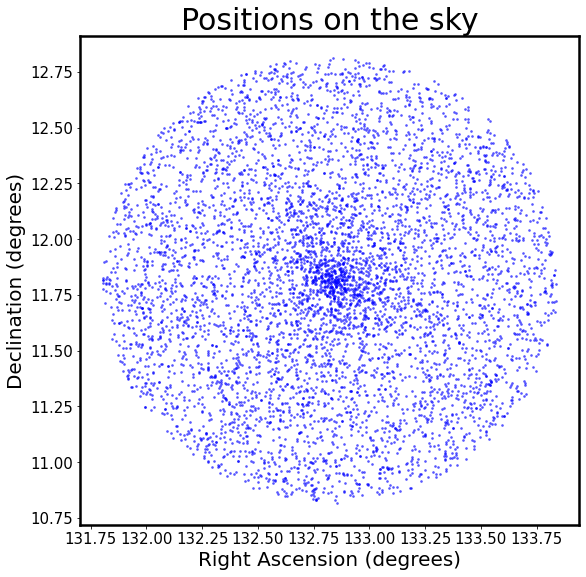

In [9]:
fs = 20 # increase the font size

fig, ax = plt.subplots(figsize=(9,9)) 
ax.scatter(gaia_data['ra'], gaia_data['dec'],s=3,alpha=0.5,c='blue')  ###### You can try different symbols sizes (s=), symbols transparency values (alpha=), and symbol colors (c='')
ax.set_aspect('equal')

ax.set_title('Positions on the sky',fontsize=30)
ax.set_xlabel("Right Ascension (degrees)",fontsize=fs)
ax.set_ylabel("Declination (degrees)",fontsize=fs)

# Make plot look nice
ax.tick_params(axis='both', which='major', labelsize=15)
aw = 2.5
ax.spines['top'].set_linewidth(aw)
ax.spines['left'].set_linewidth(aw)
ax.spines['right'].set_linewidth(aw)
ax.spines['bottom'].set_linewidth(aw)

plt.show()

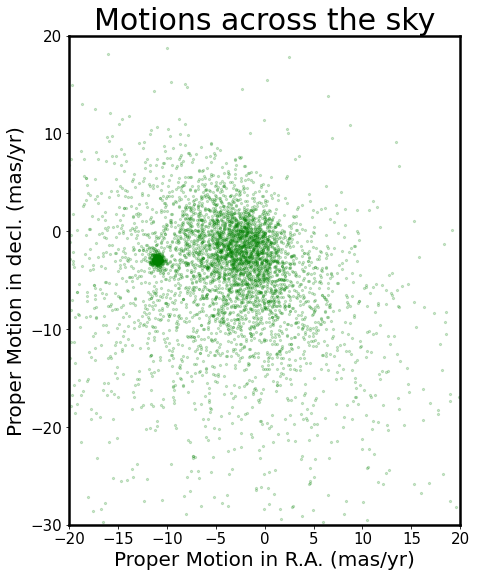

In [10]:
# Plot the Proper Motions 

fig, ax = plt.subplots(figsize=(9,9)) 
#ax.scatter(gaia_data['pmra'], gaia_data['pmdec'],s=35,alpha=0.05,c='green')
ax.scatter(gaia_data['pmra'], gaia_data['pmdec'],s=5,alpha=0.2,c='green')


#ax.scatter(gaia_data['ra'], gaia_data['dec'],s=1,alpha=0.5,c='blue')
ax.set_aspect('equal')

ax.set_xlim(-20,20)
ax.set_ylim(-30,20)
ax.set_xlabel("Proper Motion in R.A. (mas/yr)",fontsize=20)
ax.set_ylabel("Proper Motion in decl. (mas/yr)",fontsize=fs)
ax.set_title('Motions across the sky',fontsize=30)

# Make plot look nice
ax.tick_params(axis='both', which='major', labelsize=15)
aw = 2.5
ax.spines['top'].set_linewidth(aw)
ax.spines['left'].set_linewidth(aw)
ax.spines['right'].set_linewidth(aw)
ax.spines['bottom'].set_linewidth(aw)

plt.show()

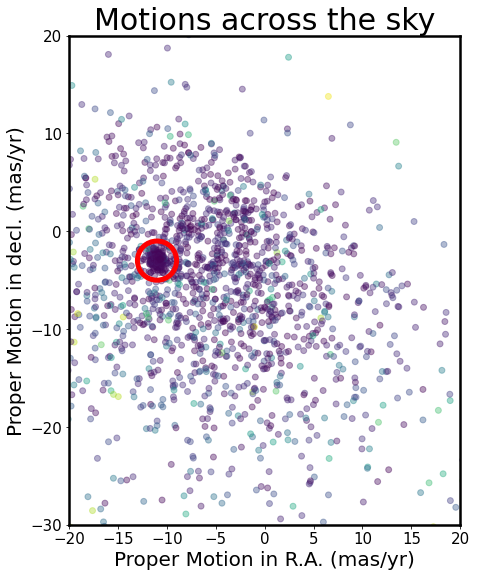

-10.972870069644335 -2.919442706295867


In [18]:
# Plug in our by-eye approximation for its pmra and pmde:

##############################
pmra_target = -11   #
pmde_target = -3  #
pm_cut = 2        # how big of a circle to select
##############################

# Calculate how much different every star is from this central value. Basically pythagorean theorem.
pm_deviation = np.sqrt((gaia_data['pmra']-pmra_target)**2+(gaia_data['pmdec']-pmde_target)**2)

ii = np.where((gaia_data['parallax'] > 1) & (gaia_data['parallax'] < 6))
fig, ax = plt.subplots(figsize=(9,9)) 
ax.scatter(gaia_data['pmra'][ii[0]], gaia_data['pmdec'][ii[0]],s=35,alpha=0.4,c=gaia_data['parallax'][ii[0]])
clump = plt.Circle((pmra_target, pmde_target), pm_cut, color='red', fill=False,linewidth=5)
ax.add_artist(clump)

ax.set_aspect('equal')

ax.set_xlim(-20,20)
ax.set_ylim(-30,20)
ax.set_xlabel("Proper Motion in R.A. (mas/yr)",fontsize=20)
ax.set_ylabel("Proper Motion in decl. (mas/yr)",fontsize=fs)
ax.set_title('Motions across the sky',fontsize=30)

# Make plot look nice
ax.tick_params(axis='both', which='major', labelsize=15)
aw = 2.5
ax.spines['top'].set_linewidth(aw)
ax.spines['left'].set_linewidth(aw)
ax.spines['right'].set_linewidth(aw)
ax.spines['bottom'].set_linewidth(aw)

plt.show()

# We can recalcualte the median proper motions values to see how close we were by eye:
# Which stars have a proper motion deviation less than 10 mas/yr?
i_members_v1 = np.where(pm_deviation < pm_cut)
print(np.median(gaia_data['pmra'][i_members_v1[0]]), np.median(gaia_data['pmdec'][i_members_v1[0]]))

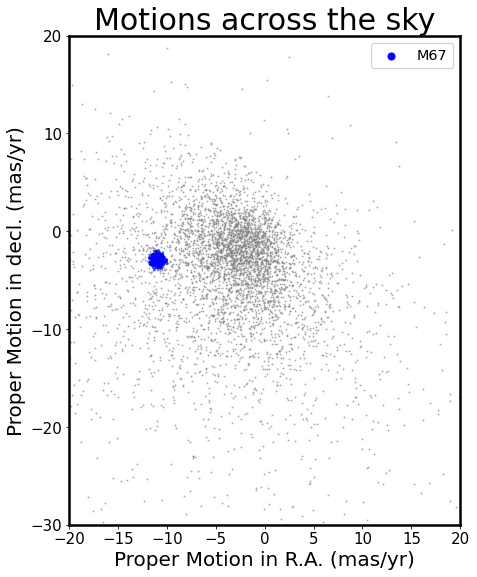

In [21]:
# It looks like we were off by a bit in pmra. Let's redo the membership selection:
pmra_target = np.nanmedian(gaia_data['pmra'][i_members_v1[0]])
pmde_target = np.nanmedian(gaia_data['pmdec'][i_members_v1[0]])
pm_deviation = np.sqrt((gaia_data['pmra']-pmra_target)**2+(gaia_data['pmdec']-pmde_target)**2)
# Now lets tighten up the criteria:

##############################
pm_cut = 1.0  # Adjust this number to tighten up the selection. 
##############################


i_members_v1 = np.where(pm_deviation < pm_cut)

fig, ax = plt.subplots(figsize=(9,9)) 
ax.scatter(gaia_data['pmra'], gaia_data['pmdec'],s=1,alpha=0.5,c='gray')
ax.scatter(gaia_data['pmra'][i_members_v1[0]], gaia_data['pmdec'][i_members_v1[0]],s=5,alpha=0.5,c='blue')

ax.set_aspect('equal')

ax.set_xlim(-20,20)
ax.set_ylim(-30,20)
ax.set_xlabel("Proper Motion in R.A. (mas/yr)",fontsize=20)
ax.set_ylabel("Proper Motion in decl. (mas/yr)",fontsize=fs)
ax.set_title('Motions across the sky',fontsize=30)

# Make plot look nice
ax.tick_params(axis='both', which='major', labelsize=15)
aw = 2.5
ax.spines['top'].set_linewidth(aw)
ax.spines['left'].set_linewidth(aw)
ax.spines['right'].set_linewidth(aw)
ax.spines['bottom'].set_linewidth(aw)

#ax.scatter(3,-5,c='gray',s=50,label='Everything else')
ax.scatter(pmra_target,pmde_target,c='blue',s=50,label=cluster_name)
ax.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.4, fontsize="x-large")

plt.show()



# That's better

**What does the color$-$magnitude diagram look like?**

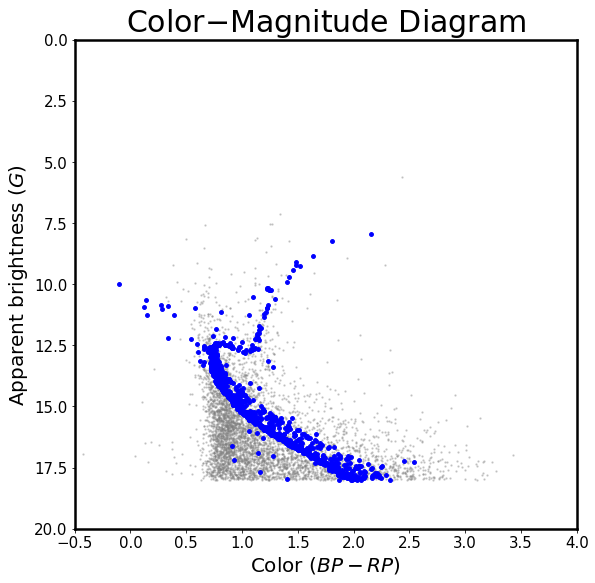

In [22]:
# Let's highlight the cluster members

fig, ax = plt.subplots(figsize=(9,9)) 
ax.scatter(gaia_data['bp_rp'], gaia_data['phot_g_mean_mag'],s=2,alpha=0.3,c='gray')
plt.scatter(gaia_data['bp_rp'][i_members_v1[0]], gaia_data['phot_g_mean_mag'][i_members_v1[0]],s=15,c='blue')

ax.set_ylim(20,0)
ax.set_xlim(-0.5,4)
ax.set_xlabel("Color ($BP - RP$)",fontsize=fs)
ax.set_ylabel("Apparent brightness ($G$)",fontsize=fs)
ax.set_title('Color$-$Magnitude Diagram',fontsize=30)

# Make plot look nice
ax.tick_params(axis='both', which='major', labelsize=15)
aw = 2.5
ax.spines['top'].set_linewidth(aw)
ax.spines['left'].set_linewidth(aw)
ax.spines['right'].set_linewidth(aw)
ax.spines['bottom'].set_linewidth(aw)

plt.show()

In [23]:
number_of_targets = len(gaia_data)
number_of_members = len(i_members_v1[0])
print("We found "+str(number_of_members)+" members of the cluster out of "+str(number_of_targets)+" stars in its vicinity")
print()
print("That is "+str(number_of_members/number_of_targets*100)+" percent") # need to look up how to round numbers or print more compactly.

We found 1183 members of the cluster out of 6103 stars in its vicinity

That is 19.38390955267901 percent


**How far away are the stars: the parallax histogram**

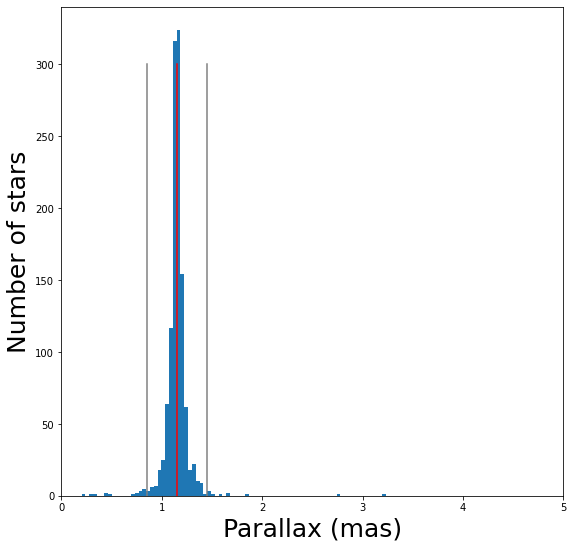

1.1522294193220306


In [30]:
########################
plx_target = 1.15
plx_cut = 0.3
yhist = 300
########################
fig, ax = plt.subplots(figsize=(9,9)) 
ax.hist(gaia_data['parallax'][i_members_v1[0]],bins=80)
ax.set_xlim(0,5)
ax.plot([plx_target,plx_target],[0,yhist],c='red')
ax.plot([plx_target+plx_cut, plx_target+plx_cut],[0,yhist],c='gray')
ax.plot([plx_target-plx_cut, plx_target-plx_cut],[0,yhist],c='gray')
ax.set_xlabel('Parallax (mas)',fontsize=25)
ax.set_ylabel('Number of stars',fontsize=25)
plt.show()

########################
i_members = np.where( (pm_deviation < pm_cut) & (abs(gaia_data['parallax'] - plx_target) < plx_cut) )
print(np.nanmedian(gaia_data['parallax'][i_members[0]]))

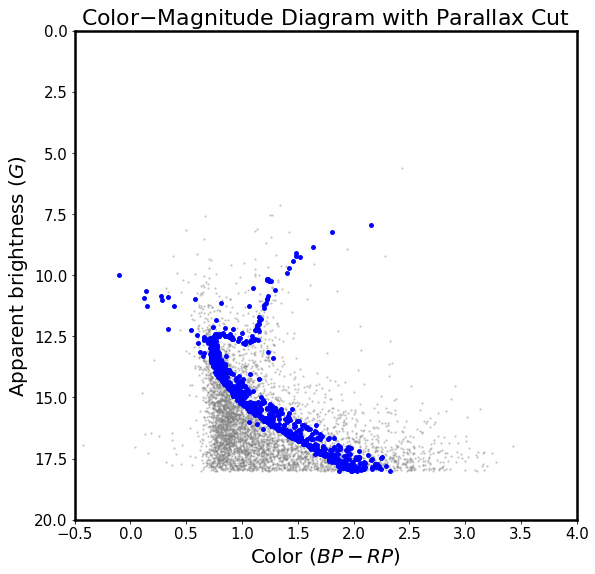

1156

In [31]:
# Let's highlight the cluster members
# And let's make it look nice

fig, ax = plt.subplots(figsize=(9,9)) 
ax.scatter(gaia_data['bp_rp'], gaia_data['phot_g_mean_mag'],s=2,alpha=0.3,c='gray')
plt.scatter(gaia_data['bp_rp'][i_members[0]], gaia_data['phot_g_mean_mag'][i_members[0]],s=15,c='blue')

ax.set_ylim(20,0)
ax.set_xlim(-0.5,4)
ax.set_xlabel("Color ($BP - RP$)",fontsize=fs)
ax.set_ylabel("Apparent brightness ($G$)",fontsize=fs)
ax.set_title('Color$-$Magnitude Diagram with Parallax Cut',fontsize=22)

# Make plot look nice
ax.tick_params(axis='both', which='major', labelsize=15)
aw = 2.5
ax.spines['top'].set_linewidth(aw)
ax.spines['left'].set_linewidth(aw)
ax.spines['right'].set_linewidth(aw)
ax.spines['bottom'].set_linewidth(aw)

plt.show()

len(i_members[0])

**Radial velocities: do our members have a common RV?**

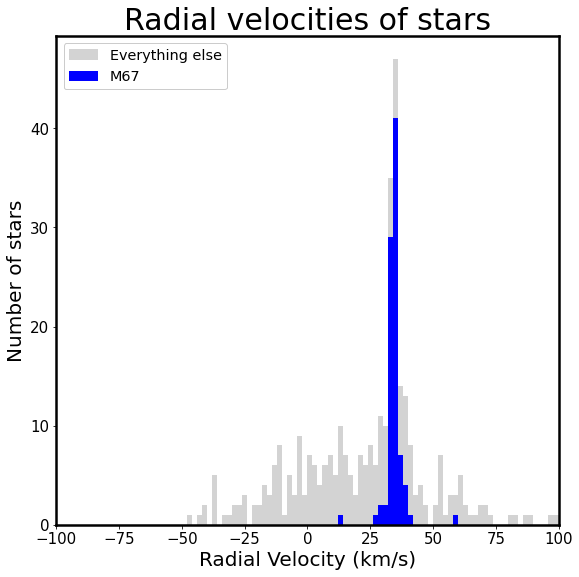

In [32]:
# Not every star has an RV
# Select those with actual measurements by asking which stars have finite RV values?
irv = np.where(np.isfinite(gaia_data['radial_velocity']) == True)
# And repeat this using our proper motion selection criteria:
irv_mem = np.where((np.isfinite(gaia_data['radial_velocity']) == True) & (pm_deviation < pm_cut) & (abs(gaia_data['parallax']-plx_target)<plx_cut))

fig, ax = plt.subplots(figsize=(9,9)) 
ax.hist(gaia_data['radial_velocity'][irv[0]],bins=100, range=(-100,100),facecolor='lightgray',label='Everything else')
ax.hist(gaia_data['radial_velocity'][irv_mem[0]],bins=100, range=(-100,100),facecolor='blue',label=cluster_name)
ax.set_xlim(-100,100)
ax.set_xlabel('Radial Velocity (km/s)',fontsize=fs)
ax.set_ylabel('Number of stars',fontsize=fs)
ax.set_title('Radial velocities of stars',fontsize=30)

ax.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.4, fontsize="x-large")

# Make plot look nice
ax.tick_params(axis='both', which='major', labelsize=15)
aw = 2.5
ax.spines['top'].set_linewidth(aw)
ax.spines['left'].set_linewidth(aw)
ax.spines['right'].set_linewidth(aw)
ax.spines['bottom'].set_linewidth(aw)

plt.show()

**Spatial Distribution**

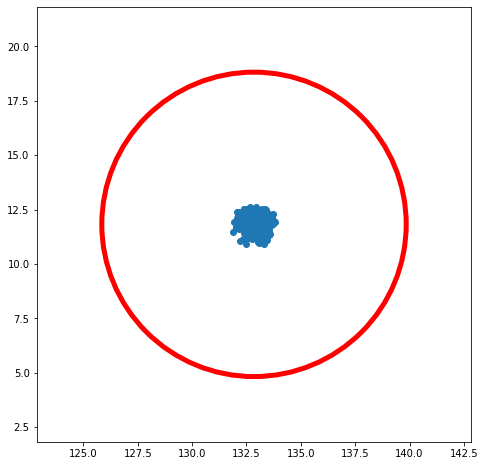

In [33]:
ra_target  = np.nanmedian(gaia_data['ra'][i_members[0]])
de_target  = np.nanmedian(gaia_data['dec'][i_members[0]])
plot_radius = 10.0
cluster_radius = 7.0

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(gaia_data['ra'][i_members[0]], gaia_data['dec'][i_members[0]])
ax.set_xlim(ra_target - plot_radius, ra_target + plot_radius)
ax.set_ylim(de_target - plot_radius, de_target + plot_radius)
clump = plt.Circle((ra_target, de_target), cluster_radius, color='red', fill=False, linewidth=5)
ax.add_artist(clump)
ax.set_aspect('equal')


In [34]:
# Galactic Cartesian Coordinates (XYZ) and Velocities (UVW)
c1 = coord.SkyCoord(ra=np.array(gaia_data['ra'])*u.degree, dec=np.array(gaia_data['dec'])*u.degree,
                    distance=(1e3/np.array(gaia_data['parallax']))*u.pc,
                    pm_ra_cosdec=np.array(gaia_data['pmra'])*u.mas/u.yr,
                    pm_dec=np.array(gaia_data['pmdec'])*u.mas/u.yr,
                    radial_velocity=np.array(gaia_data['radial_velocity'])*u.km/u.s,
                    frame='icrs')

gc1 = c1.transform_to(coord.Galactocentric)

x_cb = np.nanmedian(gc1.x[i_members[0]])
y_cb = np.nanmedian(gc1.y[i_members[0]])
z_cb = np.nanmedian(gc1.z[i_members[0]])

u_cb = np.nanmedian(gc1.v_x[i_members[0]])
v_cb = np.nanmedian(gc1.v_y[i_members[0]])
w_cb = np.nanmedian(gc1.v_z[i_members[0]])

print("X = "+str(x_cb)+",      Y = " +str(y_cb)+",       Z = " +str(z_cb))
print("U = "+str(u_cb)+",  V = " +str(v_cb)+",  W = " +str(w_cb))

# XYZ deviation from cluster average
dgal = np.sqrt((gc1.x - x_cb)**2+(gc1.y - y_cb)**2+(gc1.z - z_cb)**2)
# UVW deviation from cluster average
duvw = np.sqrt((gc1.v_x - u_cb)**2+(gc1.v_y - v_cb)**2+(gc1.v_z - w_cb)**2)

X = -8719.028093764995 pc,      Y = -429.3835021517622 pc,       Z = 481.4750173109473 pc
U = -35.035001325585014 km / s,  V = 221.15948883461255 km / s,  W = -12.277702402727487 km / s


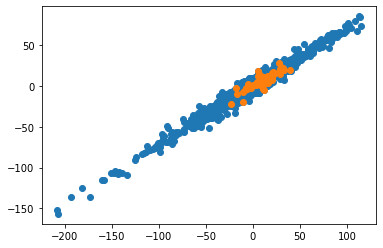

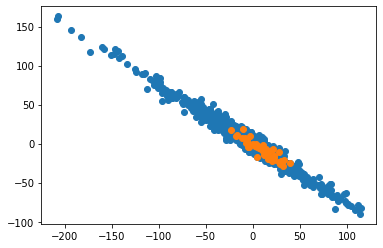

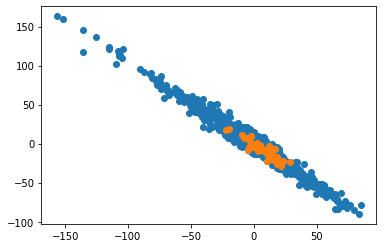

56

In [35]:
mg = gaia_data['phot_g_mean_mag'] - 5*np.log10(100/gaia_data['parallax'])
ii = np.where((duvw < 3*u.km/u.s) & (abs(gc1.z-z_cb)<30*u.pc) & (gaia_data['erv'] < 4*u.km/u.s) & (gaia_data['ruwe']<1.4))
itail = np.where((duvw < 3*u.km/u.s) & (abs(gc1.z-z_cb)<30*u.pc) & (gaia_data['erv'] < 4*u.km/u.s) & (gaia_data['ruwe']<1.4) & (dgal > 30*u.pc) & (gaia_data['bp_rp']>0.87) & (mg > 3))

plt.scatter(gc1.x[i_members[0]]-x_cb, gc1.y[i_members[0]]-y_cb)
plt.scatter(gc1.x[ii[0]]-x_cb, gc1.y[ii[0]]-y_cb)
plt.show()

plt.scatter(gc1.x[i_members[0]]-x_cb, gc1.z[i_members[0]]-z_cb)
plt.scatter(gc1.x[ii[0]]-x_cb, gc1.z[ii[0]]-z_cb)
plt.show()

plt.scatter(gc1.y[i_members[0]]-y_cb, gc1.z[i_members[0]]-z_cb)
plt.scatter(gc1.y[ii[0]]-y_cb, gc1.z[ii[0]]-z_cb)
plt.show()

len(ii[0])

In [ ]:
ra_target  = np.nanmedian(gaia_data['ra'][i_members[0]])
de_target  = np.nanmedian(gaia_data['dec'][i_members[0]])
plot_radius = 20.0
cluster_radius = 7.0

fig, ax = plt.subplots(figsize=(8,8))
#ax.scatter(gaia_data['ra'][i_members[0]], gaia_data['dec'][i_members[0]])
ax.scatter(gaia_data['ra'][ii[0]], gaia_data['dec'][ii[0]])
ax.set_xlim(ra_target - plot_radius, ra_target + plot_radius)
ax.set_ylim(de_target - plot_radius, de_target + plot_radius)
clump = plt.Circle((ra_target, de_target), cluster_radius, color='red', fill=False, linewidth=5)
#ax.add_artist(clump)
ax.set_aspect('equal')


In [ ]:
plt.scatter(gc1.v_x[i_members[0]]-u_cb, gc1.v_y[i_members[0]]-v_cb)
plt.show()

plt.scatter(gc1.v_x[i_members[0]]-u_cb, gc1.v_z[i_members[0]]-w_cb)
plt.show()

plt.scatter(gc1.v_y[i_members[0]]-v_cb, gc1.v_z[i_members[0]]-w_cb)
plt.show()

In [ ]:
pmra_target  = np.nanmedian(gaia_data['pmra'][i_members[0]])
pmde_target  = np.nanmedian(gaia_data['pmdec'][i_members[0]])
plot_radius = 5.0
cluster_radius = 2.0

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(gaia_data['pmra'][i_members[0]], gaia_data['pmdec'][i_members[0]])
ax.scatter(gaia_data['pmra'][ii[0]], gaia_data['pmdec'][ii[0]])
ax.set_xlim(pmra_target - plot_radius, pmra_target + plot_radius)
ax.set_ylim(pmde_target - plot_radius, pmde_target + plot_radius)
ax.set_aspect('equal')


In [ ]:
plt.scatter(gaia_data['pmdec'][ii[0]], 1e3/gaia_data['parallax'][ii[0]])

In [ ]:
plt.scatter(gaia_data['bp_rp'][ii[0]], gaia_data['phot_g_mean_mag'][ii[0]] - 5*np.log10(100/gaia_data['parallax'][ii[0]]))
plt.scatter(gaia_data['bp_rp'][itail[0]], gaia_data['phot_g_mean_mag'][itail[0]] - 5*np.log10(100/gaia_data['parallax'][itail[0]]))
#plt.ylim(8,1)

for i in range(len(itail[0])):
  print(i, gaia_data['source_id'][itail[0][i]],gaia_data['ra'][itail[0][i]], gaia_data['dec'][itail[0][i]], gaia_data['phot_g_mean_mag'][itail[0][i]], dgal[itail[0][i]])

In [ ]:
gaia_data[0]

In [ ]:
gaia_data['erv'][ii[0]]

**How many stars did we find in the cluster?**

In [ ]:
number_of_targets = len(gaia_data)
number_of_members = len(i_members[0])
print("We found "+str(number_of_members)+" members of "+cluster_name+" out of "+str(number_of_targets)+" stars in its vicinity")
print()
print("That is "+str(number_of_members/number_of_targets*100)+" percent") # need to look up how to round numbers or print more compactly.

**Saving the results to file**

In [ ]:
# Do you want to save the results to file? Change from False to True. Be careful, it will overwrite existing files with that name.
save_table = False # I suggest changing this back to False after you have it save your table.

# Set the cluster name. This will be the file name.
File_ClusterName = 'NGC_7092-2020Dec26'

# If you want to save, then do these things:
if save_table == True:
  # You have to give permission to the notebook to access files stored in your Google Drive. 
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  
  # Set up our directories
  dir_main = '/content/gdrive/My Drive/'
  dir_table = dir_main + 'Tables/'

  # Import pandas so we can write a csv file
  import pandas as pd

  # Organize the data into a pandas data frame
  cluster = {'Source':gaia_data['source_id'][i_members[0]], 'RA':gaia_data['ra'][i_members[0]], 'Dec':gaia_data['dec'][i_members[0]], 'parallax':gaia_data['parallax'][i_members[0]], 'pmra':gaia_data['pmra'][i_members[0]], 'pmde':gaia_data['pmdec'][i_members[0]], 'Gmag':gaia_data['phot_g_mean_mag'][i_members[0]], 'bp_rp':gaia_data['bp_rp'][i_members[0]], 'RV':gaia_data['radial_velocity'][i_members[0]]}
  cluster = pd.DataFrame(cluster)

  # create the csv file
  cluster.to_csv(dir_table+File_ClusterName+'.csv')